###Preparation

In [185]:
pip install thinkx

In [186]:
import matplotlib.pyplot as plt

In [187]:
try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist
from empiricaldist import *

In [188]:
pip install PyGithub requests

In [189]:
import requests 
import json
from github import Github
import pandas as pd

In [190]:
from datetime import datetime

### Data Colllection

##### Authorization

In [191]:
BT_TOCKEN = 'student_tocken' #for authorised API requests there are looses limit on the number of calls.
g = Github(login_or_token=BT_TOCKEN)

##### Getting Raw Data

In [192]:
#Getting repository object to access its constituent elements
repo = g.get_repo(full_name_or_id='golang/go')
issues = repo.get_issues(state='closed', since=datetime.strptime("2021-05-10", "%Y-%m-%d")) #Getting all closed issues over year period

In [198]:
#getting issues parametrs
issues_list = {}
for i in range(issues.totalCount):
  issues_list[issues[i].id] = [issues[i].id, issues[i].created_at, issues[i].closed_at, issues[i].get_comments().totalCount]
issue_dates = pd.json_normalize(issues_list)

In [217]:
df = pd.DataFrame(issues_list)
df.T.to_excel('to_clean.xlsx')

###Data Aggeration


#### Problem level

#####Cleaning

In [218]:
to_clean = pd.read_excel('to_clean.xlsx', names=['id', 'created_at', 'closed_at', 'Comments_num']) #loading 
cleaned_df = to_clean.drop_duplicates() #excluding duplicates that might have resulted from API failures
cleaned_df.to_excel('cleaned.xlsx') #saving

In [219]:
to_clean.head()

,id,created_at,closed_at,Comments_num
1237919053,1237919053,2022-05-17 01:07:27,2022-05-17 01:17:14,1
1237631077,1237631077,2022-05-16 19:44:55,2022-05-16 19:54:01,0
1237532717,1237532717,2022-05-16 18:20:58,2022-05-17 00:54:26,7
1237493471,1237493471,2022-05-16 17:46:42,2022-05-16 17:47:44,0
1237369351,1237369351,2022-05-16 15:59:18,2022-05-17 18:18:43,3


In [220]:
#Before estimating waiting times between subsequent issues one must make sure they follow in order.
sorted = cleaned_df.sort_values(by = 'created_at', ascending=True)

In [222]:
#The code defines lenth of the elapsed time in minutes one by one so that each issue has atteched info on the time past since the previous one.
tdiffs = {}
for i in range (1, sorted.shape[0]):
  tdiffs[i] = [(sorted.iloc[i]['created_at'] - sorted.iloc[i - 1]['created_at']).total_seconds() / 60]

In [223]:
diffs_df = pd.DataFrame(tdiffs)
diffs_df = diffs_df.T

In [ ]:
diffs_df

,0
1,5840.233333
2,31680.533333
3,24101.783333
4,71254.133333
5,493332.366667
...,...
10449,25.916667
10450,13.033333
10451,34.516667
10452,75.433333


In [ ]:
diffs_df.to_excel('diff.xlsx') #saving data to use later

####Repo Level

In [231]:
issue_df = pd.read_excel('issues per hour.xlsx') #loading issue data
issue_df = issue_df.fillna(0)
issue_df.head()

,Hour of Created At,Distinct count of Id
0,"May 11, 2022 4 PM",1.0
1,"May 11, 2022 3 PM",1.0
2,"May 11, 2022 2 PM",1.0
3,"May 11, 2022 1 PM",3.0
4,"May 11, 2022 12 PM",0.0


######Avalanche size

In [167]:
# for known number of avalanches we compute durations of each single one by computing the total number of issues for subsequent bins with non-zero value of issue created
list_av = {}
list_av['0'] = 1 #initializing the first bin
j = 0
for i in range(1, 51145):
  if issue_df['Distinct count of Id'].iloc[i - 1] < 1 and issue_df['Distinct count of Id'][i] > 0:
    j += 1
    list_av[str(j)] = 0
    list_av[str(j)] += issue_df['Distinct count of Id'][i]
  elif issue_df['Distinct count of Id'][i] > 0:
    list_av[str(j)] += issue_df['Distinct count of Id'][i]

In [127]:
#Saving the data for the subsequent analysis
size_df = pd.DataFrame(list_av, index=[0])
size_df.T.to_excel('size_data.xlsx')

In [177]:
size_df = pd.read_excel('size_data.xlsx')

In [181]:
pmfAvSize = Pmf.from_seq(size_df[0]) #getting mass probability data from the empirical data

#####Avalanche duration

In [242]:
# for known number of avalanches we compute durations of each single one by counting number of subsequent bins with non-zero value of issue created
list_durations = [[0.0, 0.0] for j in range(4124)] #the first number corresponds to avalanch duration and the second to the waiting-times as counts intermittent bins
list_durations[0] = [1.0, 1] #for the first one there is no previous avalanch
j = 0
for i in range(1, 51145):
  if issue_df['Distinct count of Id'].iloc[i - 1] < 1.0 and issue_df['Distinct count of Id'][i] > 0:
    j += 1
    list_durations[j][0] += 1
    list_durations[j][1] = i
  elif issue_df['Distinct count of Id'][i] > 0:
    list_durations[j][0] += 1
  elif issue_df['Distinct count of Id'][i - 1] < 1.0:
        list_durations[j][1] += (1)

In [246]:
pmfAvDurations = Pmf.from_seq([l[0] for l in list_durations]) #getting mass probability data from the empirical data

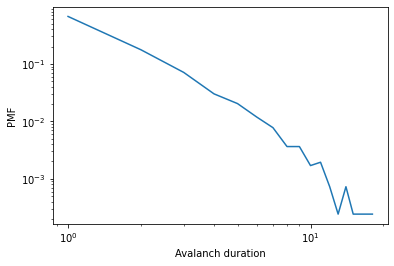

In [251]:
pmfAvDurations.plot(logy = True, logx=True, xlabel = 'Avalanch duration', ylabel = 'PMF')


#####Alternative

In [ ]:
list_dur = [datetime.strptime(issue_df['Hour of Created At'].iloc[av[1]], "%B %d, %Y %I %p") for av in list_durations]
list_durs = [abs((list_dur[i] - list_dur[i - 1]).total_seconds() // 60) for i in range(1, 4123)]
list_durs

In [244]:
av_dur_series = pd.Series(list_durs)

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:518: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(self.xlim)


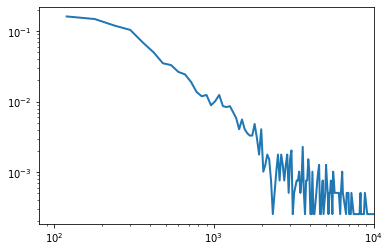

In [ ]:
pmfAvDur = Pmf.from_seq(av_dur_series[av_dur_series > 60])
pmfAvDur.plot(logy=True, logx=True, xlim=(0, 10000))

In [ ]:
dur = pd.DataFrame(list_dur, index=[0])

In [ ]:
dur.T.to_excel('av_dur.xlsx')

In [ ]:
df = pd.DataFrame(list_av)

In [ ]:
df.T.to_excel('list_avxlsx')

#####Numerical durations and waiting times

In [ ]:
temporal_dict = {'Durations':[av[0] for av in list_durations], 'Waiting times':[av[1] for av in list_durations]}
temporal_df = pd.DataFrame(temporal_dict)
temporal_df

In [131]:
temporal_df.to_excel('temporal_data.xlsx')
temporal_df = pd.read_excel('temporal_data.xlsx')

### Problem level

####Getting PMF

In [ ]:
#Loading prepared data on waiting times and avalanche size
diffs_df = pd.read_excel('diffs.xlsx')
activity_df = pd.read_excel('cleaned.xlsx')

In [ ]:
#Getting probability mass function and cumulative distribution function for waiting-times
pmfDiff = Pmf.from_seq(diffs_df[0][diffs_df[0] > 1])
cdfDiff = Cdf.from_seq(diffs_df[0][diffs_df[0] > 1])

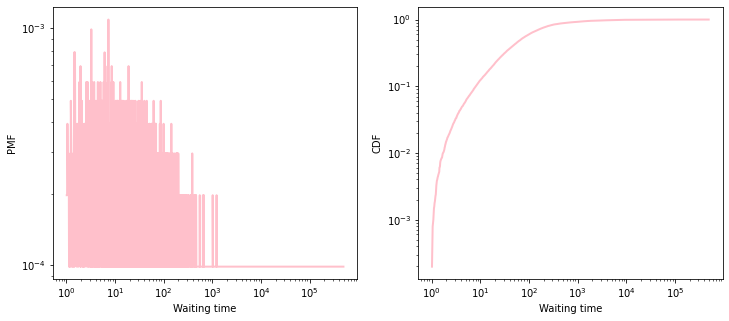

In [ ]:
#Visualizing pmf and pdf obtained on the step
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
pmfDiff.plot(logy = True, logx = True, xlabel = 'Waiting time', ylabel = 'PMF', color='pink')


plt.subplot(1, 2, 2)
cdfDiff.plot(logy = True, logx = True, xlabel = 'Waiting time', ylabel = 'CDF', color='pink')


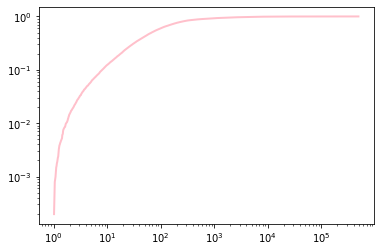

In [ ]:
cdfDiff.plot(logy = True, logx = True, color='pink')

####Fitting

In [114]:
issue_df_agg = pd.read_excel('cleaned.xlsx')

In [115]:
issue_df_agg.tail()

,Issue ID,Events Num,Comments Num,Minutes
11454,109616822,8,8,-3399823
11455,108376497,5,2,-3410987
11456,107794838,20,25,-3415091
11457,104983422,8,2,-3440867
11458,100818968,12,3,-3264739


In [17]:
#The issues got sorted into inverse order thusnegative duration of elapsed time wereobtained
issue_df_agg[issue_df_agg['Minutes'] < 0] = issue_df_agg[issue_df_agg['Minutes'] < 0].apply(abs)
issue_df_agg

,Issue ID,Events Num,Comments Num,Minutes
0,1038970792,17,5,1082
1,1038968824,10,2,15495
2,1038962223,43,45,132704
3,1038860101,1,2,7
4,1038643050,10,5,220869
...,...,...,...,...
11454,109616822,8,8,3399823
11455,108376497,5,2,3410987
11456,107794838,20,25,3415091
11457,104983422,8,2,3440867


In [18]:
pmfT = Pmf.from_seq((issue_df_agg[issue_df_agg['Minutes'] > 0])['Minutes']) #excluding to small avalanches that are probably issues made by mistake
pmfSComm = Pmf.from_seq((issue_df_agg[issue_df_agg['Comments Num'] > 1])['Comments Num']) #excluding trivial issues

In [ ]:
pmfSComm.to_excel('pmfSComm.xlsx')
pmfT.to_excel('pmfT.xlsx')

In [62]:
#The method is to be used to estimate powerlaw scaling exponent
from scipy.optimize import curve_fit
def powerlaw_f(x, a, sigma):
  return sigma * x**a

In [75]:
#Loading pmf data for problem-level avalanches size and duration
pmfT_df = pd.read_excel('pmfT.xlsx', names=['Value', 'Probability']) #avalanche duration data
pmfSComm_df = pd.read_excel('pmfSComm.xlsx', names=['Value', 'Probability']) #avalanche size data

In [116]:
#Fitting pmf to obtain powerlaw parametrs
#duration
poptT, pcovT = curve_fit(powerlaw_f, xdata=pmfT_df['Value'], ydata=pmfT_df['Probability'], p0=[2, 0]) #fitting the curve for given pmf
x_modelT = np.linspace(min(pmfT_df['Value']), max(pmfT_df['Value']), 1000) #generating data with adjusted parametr for plotting
y_modelT = powerlaw_f(x_modelT, poptT[0], poptT[1])
#size
poptSizeCom, pcovSizeCom = curve_fit(powerlaw_f, xdata=pmfSComm_df['Value'], ydata=pmfSComm_df['Probability'], p0=[1.5, 0.5]) #fitting the curve for given pmf
x_modelSizeCom = np.linspace(min(pmfT_df['Value']), max(pmfT_df['Value']), 1000) #generating data with adjusted parametr for plotting
y_modelSizeCom = powerlaw_f(x_modelSizeCom, poptSizeCom[0], poptSizeCom[1])

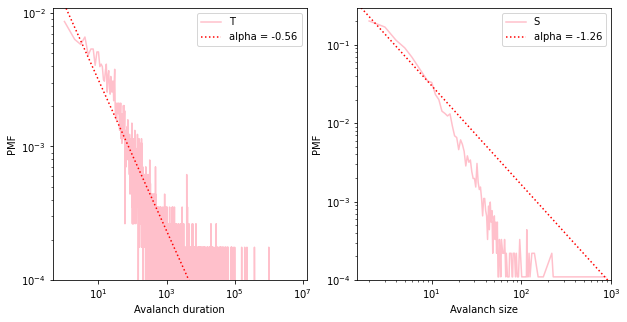

In [103]:
from matplotlib import axes
plt.figure(figsize=(10, 5))
#duration
plt.subplot(1, 2, 1)
pmfT.plot(label='T', logy = True, logx = True, xlabel = 'Avalanch duration', ylabel = 'PMF', color='pink', ylim=(10**(-4), None))
plt.loglog(x_modelT, y_modelT, ':', label = f'alpha = {round(poptT[0], 2)}', color='red')
plt.legend()
#size
plt.subplot(1, 2, 2)
pmfSComm.plot(label='S', logy = True, logx = True, xlabel = 'Avalanch size', ylabel = 'PMF', color='pink', ylim=(10**(-4), None), xlim=(None, 10**(3)))
plt.loglog(x_modelSizeCom, y_modelSizeCom, ':', label = f'alpha = {round(poptSizeCom[0], 2)}', color='red')
plt.legend()

In [ ]:
pmfAvDur.to_excel('pmfAvDur.xlsx')
pmfAvSize.to_excel('pmfAvSize.xlsx')

###Repo level

####Getting PMF

In [19]:
def slope(xs, ys):
    return np.diff(np.log(ys)) / np.diff(np.log(xs))

In [ ]:
import matplotlib

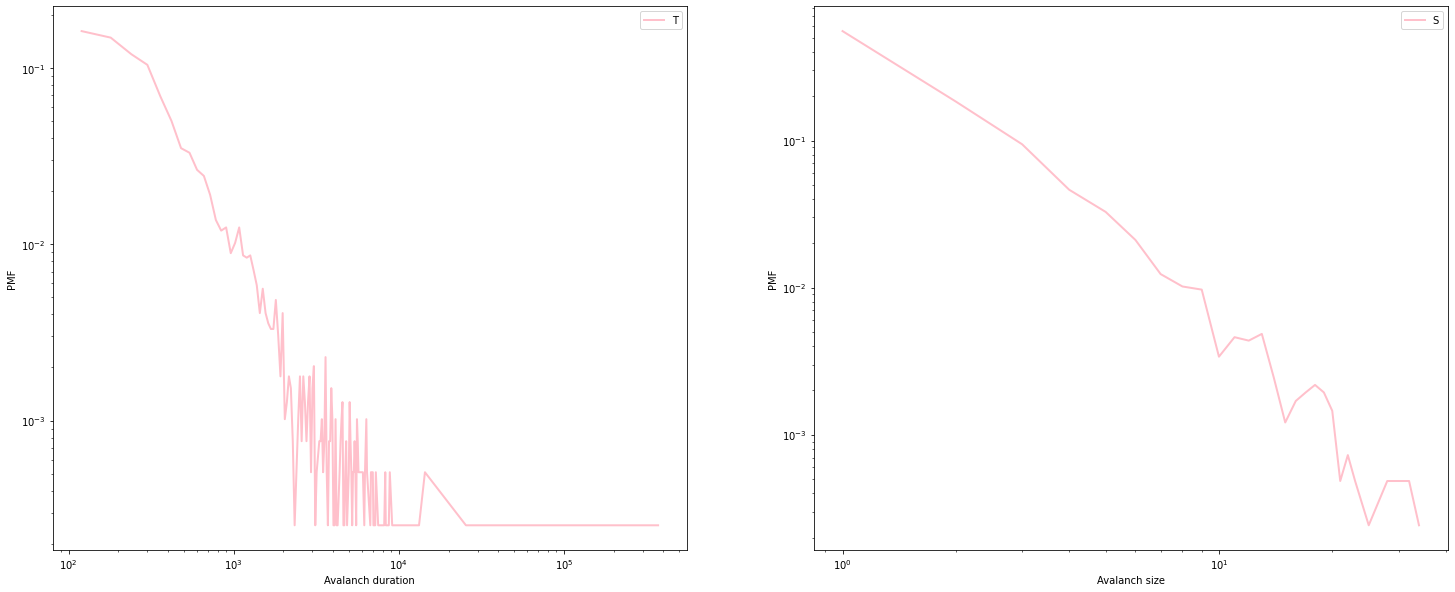

In [ ]:
from matplotlib import axes
plt.figure(figsize=(25, 10))

plt.subplot(1, 2, 1)
options = dict(lw=2, color='pink')
pmfAvDur.plot(label='T', logy = True, logx=True, xlabel = 'Avalanch duration', ylabel = 'PMF', **options)
plt.legend()

plt.subplot(1, 2, 2)
options = dict(lw=2, color='pink')
pmfAvSize.plot(label='S', logy = True, logx=True, xlabel = 'Avalanch size', ylabel = 'PMF',  **options)
plt.legend()

In [ ]:
def slope(xs, ys): #calculates scaling exponent for plotting
    return np.diff(np.log(ys)) / np.diff(np.log(xs))

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:518: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(self.xlim)


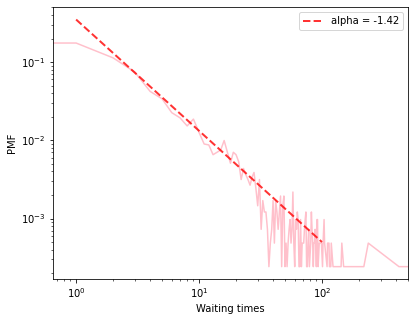

In [ ]:
pmfAvWt = Pmf.from_seq(temporal_df['Waiting times']) #obtaining waiting-times pmf from empirical data

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
pmfAvWt.plot(xlim=(0, 500) ,logy=True, logx=True, color='pink', xlabel = 'Waiting times', ylabel='PMF')
xs = [1, 100]
ys = [0.35, 0.0005]
options = dict(lw=2,  color='red', linestyle = 'dashed', alpha=0.8, label = 'alpha = '+str(round((slope(xs, ys))[0], 2)))
plt.plot(xs, ys, **options)
plt.legend()

In [ ]:
pmfAvDurations.to_excel('pmfAvDurations.xlsx') #saving obtained pmf
pmfAvWt.to_excel('pmfAvWt.xlsx') #saving obtained pmf

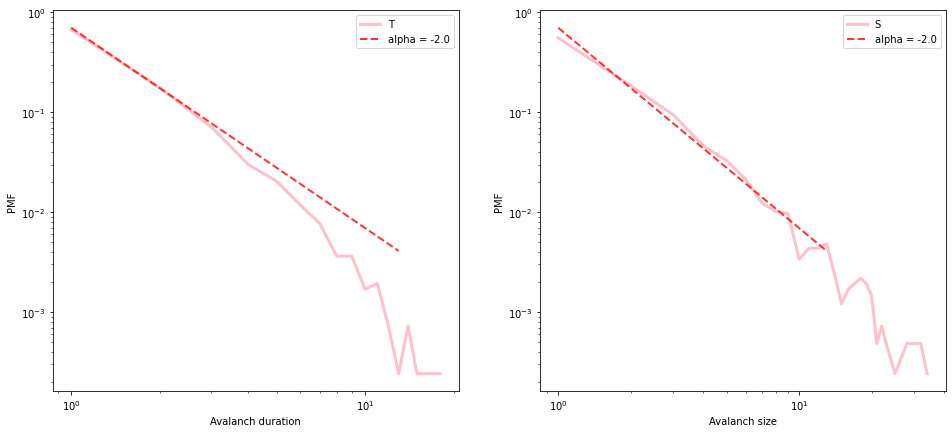

In [ ]:
from matplotlib import axes
#dashed lines are tuned to have slope of 2 in order to check assumption by Fronczak et al. 2006
plt.figure(figsize=(16, 7))

plt.subplot(1, 2, 1)
options = dict(lw=3, color='pink')
pmfAvDurations.plot(label='T', logy = True, logx=True, xlabel = 'Avalanch duration', ylabel = 'PMF', **options)

xs = [1, 13]
ys = [0.7, 0.0041]
options = dict(lw=2,  color='red', linestyle = 'dashed', alpha=0.8, label = 'alpha = '+str(round((slope(xs, ys))[0], 2)))
plt.plot(xs, ys, **options)
plt.legend()


plt.subplot(1, 2, 2)

options = dict(lw=3, color='pink')
pmfAvSize.plot(label='S', logy = True, logx=True, xlabel = 'Avalanch size', ylabel = 'PMF',  **options)
xs = [1, 13]
ys = [0.7, 0.0041]
options = dict(lw=2,  color='red', alpha=0.8, linestyle = 'dashed', label = 'alpha = '+str(round((slope(xs, ys))[0], 2)))
plt.plot(xs, ys, **options)
plt.legend()

### Testing Weibull distribution consistency

In [ ]:
pip install predictr

In [ ]:
#https://towardsdatascience.com/survival-analysis-in-python-a-quick-guide-to-the-weibull-analysis-5babd4f137f6

from predictr import Analysis, PlotAll
# Use analysis for the parameter estimation
failures = diffs_df[0]
a = Analysis(df=failures, show=False)
a.mrr()

# Use weibull_pdf method in PlotAll to plot the Weibull pdfs
# beta contains the Weibull shape parameters, which were estimated using Analysis class. Do the same for the Weibull scale parameter eta.
# Cusomize the path directory in order to use this code


In [ ]:
plotter = PlotAll() #initializing plotting class
plotter.weibull_pdf(beta = [a.beta], eta = [a.eta], linestyle=[':'], x_bounds=[0, 1, 100000], x_label='Time to Failure', y_label='Density Function', save=False, color=['pink'], **kwargs)

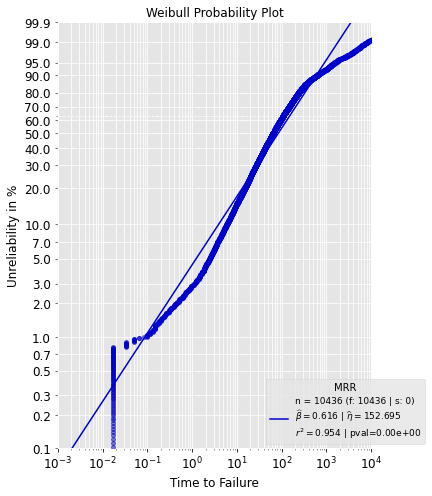

In [ ]:
from predictr import Analysis
# Data from testing
# Failures and avalanches
failures = diffs_df[0]
# Weibull Analysis
x = Analysis(df=failures, show=True)
x.mrr()

/usr/local/lib/python3.7/dist-packages/predictr.py:2983: RuntimeWarning: divide by zero encountered in power
  return beta / eta * (x / eta) ** (beta - 1) * np.exp(-1 * ((x / eta) ** beta))


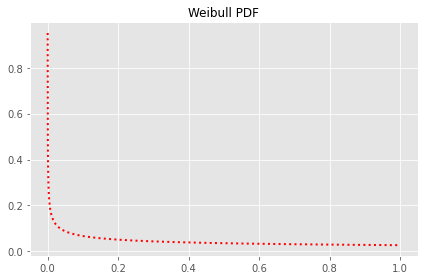

In [ ]:
#plotting fitted Weibull distribution
plotter = PlotAll()
plotter.weibull_pdf(beta=[a.beta], eta=[a.eta], linestyle=[':'], x_bounds=[0, 1, 10000], color=['red'])

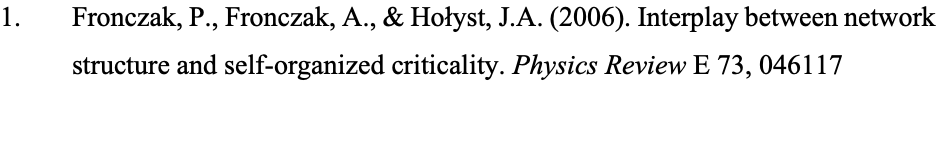